<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/CatBoost(_3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [3]:
# CatBoost Agricultural Production Classification - Enhanced with Accuracy Tracking
# Run each step one by one for better understanding

# =============================================================================
# STEP 1: INSTALL AND IMPORT REQUIRED LIBRARIES
# =============================================================================
# First, install required packages (run in terminal/command prompt):
# pip install catboost pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [4]:
# =============================================================================
# STEP 2: LOAD THE DATA
# =============================================================================
print("\n" + "="*50)
print("STEP 2: LOADING DATA")
print("="*50)

# Load the three CSV files
try:
    train_df = pd.read_csv("//content/drive/MyDrive/UpdatedDataset/train.csv")
    val_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/validation.csv")
    test_df = pd.read_csv("/content/drive/MyDrive/UpdatedDataset/test.csv")

    print(f"✓ Training data loaded: {train_df.shape}")
    print(f"✓ Validation data loaded: {val_df.shape}")
    print(f"✓ Test data loaded: {test_df.shape}")

    # Display basic info about the data
    print(f"\nFirst few columns: {list(train_df.columns[:5])}")
    print(f"Target column: Production (M.Ton)")
    print(f"Production range in training: {train_df['Production (M.Ton)'].min():.2f} - {train_df['Production (M.Ton)'].max():.2f}")

except FileNotFoundError as e:
    print("❌ Error: CSV files not found!")
    print("Please make sure you have train.csv, validation.csv, and test.csv in your working directory")
    print("Stopping execution...")
    exit()




STEP 2: LOADING DATA
✓ Training data loaded: (3942, 84)
✓ Validation data loaded: (845, 84)
✓ Test data loaded: (845, 84)

First few columns: ['Production (M.Ton)', 'Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)']
Target column: Production (M.Ton)
Production range in training: 0.00 - 544979.50


In [5]:
# =============================================================================
# STEP 3: EXPLORE THE DATA
# =============================================================================
print("\n" + "="*50)
print("STEP 3: DATA EXPLORATION")
print("="*50)

# Check for missing values
print("Missing values in training data:")
missing_values = train_df.isnull().sum()
print(f"Total missing values: {missing_values.sum()}")




STEP 3: DATA EXPLORATION
Missing values in training data:
Total missing values: 0


In [6]:



# =============================================================================
# STEP 4: CREATE QUANTILE-BASED LABELS
# =============================================================================
print("\n" + "="*50)
print("STEP 4: CREATING PRODUCTION LABELS")
print("="*50)

# Calculate quantiles from training data only
production_values = train_df['Production (M.Ton)']
low_threshold = production_values.quantile(0.33)
high_threshold = production_values.quantile(0.67)

print(f"Quantile thresholds:")
print(f"Low threshold (33rd percentile): {low_threshold:.2f}")
print(f"High threshold (67th percentile): {high_threshold:.2f}")

# Function to create labels
def create_production_labels(df, low_thresh, high_thresh):
    """Create production category labels"""
    return pd.cut(
        df['Production (M.Ton)'],
        bins=[-np.inf, low_thresh, high_thresh, np.inf],
        labels=['low', 'medium', 'high']
    )

# Apply labeling to all datasets
train_df['production_category'] = create_production_labels(train_df, low_threshold, high_threshold)
val_df['production_category'] = create_production_labels(val_df, low_threshold, high_threshold)
test_df['production_category'] = create_production_labels(test_df, low_threshold, high_threshold)

# Print distribution for each dataset
for df, name in [(train_df, 'Training'), (val_df, 'Validation'), (test_df, 'Test')]:
    print(f"\n{name} set production distribution:")
    print(df['production_category'].value_counts())
    print(f"Percentages: {(df['production_category'].value_counts(normalize=True) * 100).round(2)}")



STEP 4: CREATING PRODUCTION LABELS
Quantile thresholds:
Low threshold (33rd percentile): 1071.56
High threshold (67th percentile): 4035.91

Training set production distribution:
production_category
medium    1340
low       1301
high      1301
Name: count, dtype: int64
Percentages: production_category
medium    33.99
low       33.00
high      33.00
Name: proportion, dtype: float64

Validation set production distribution:
production_category
medium    297
low       278
high      270
Name: count, dtype: int64
Percentages: production_category
medium    35.15
low       32.90
high      31.95
Name: proportion, dtype: float64

Test set production distribution:
production_category
high      291
medium    280
low       274
Name: count, dtype: int64
Percentages: production_category
high      34.44
medium    33.14
low       32.43
Name: proportion, dtype: float64


In [7]:
# =============================================================================
# STEP 5: PREPARE FEATURES AND LABELS
# =============================================================================
print("\n" + "="*50)
print("STEP 5: PREPARING FEATURES AND LABELS")
print("="*50)

# Identify feature columns (exclude target and created category)
feature_columns = [col for col in train_df.columns
                  if col not in ['Production (M.Ton)', 'production_category']]

print(f"Total number of features: {len(feature_columns)}")
print(f"Sample features: {feature_columns[:5]}")

# Prepare features
X_train = train_df[feature_columns]
X_val = val_df[feature_columns]
X_test = test_df[feature_columns]

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['production_category'])
y_val = label_encoder.transform(val_df['production_category'])
y_test = label_encoder.transform(test_df['production_category'])

print(f"Label encoding: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")



STEP 5: PREPARING FEATURES AND LABELS
Total number of features: 83
Sample features: ['Area (Acres)', 'Temperature at 2 Meters Range (C)', 'Year', 'soil_temperature_0_to_7cm(C)', 'Root Zone Soil Wetness (surface to 100 cm below)']
Label encoding: {'high': 0, 'low': 1, 'medium': 2}
Training labels shape: (3942,)
Validation labels shape: (845,)
Test labels shape: (845,)


In [8]:
# =============================================================================
# STEP 6: INITIALIZE AND TRAIN CATBOOST MODEL WITH ENHANCED EARLY STOPPING
# =============================================================================
print("\n" + "="*50)
print("STEP 6: TRAINING CATBOOST MODEL WITH EARLY STOPPING")
print("="*50)

# Initialize CatBoost classifier with enhanced early stopping
model = CatBoostClassifier(
    iterations=1000,           # Maximum number of epochs
    learning_rate=0.1,         # Learning rate
    depth=6,                   # Tree depth
    eval_metric='MultiClass',  # Primary evaluation metric for early stopping
    custom_metric=['Accuracy'], # Additional metric to track accuracy
    random_seed=42,            # For reproducibility
    verbose=50,                # Print progress every 50 iterations

    # ENHANCED EARLY STOPPING PARAMETERS
    early_stopping_rounds=30,  # Stop if no improvement for 30 rounds (reduced from 50)
    use_best_model=True,       # Use the best model from training

    # Additional regularization to reduce overfitting
    l2_leaf_reg=3,             # L2 regularization coefficient
    bagging_temperature=1,     # Controls intensity of Bayesian bagging
    random_strength=1,         # Amount of randomness for scoring splits
)

print("Starting model training with enhanced early stopping...")
print("Early stopping will trigger if no improvement for 30 iterations")
print("This may take a few minutes depending on your data size...")

# Train model with validation data for early stopping
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    plot=False,
    verbose_eval=50  # Print every 50 iterations
)

print(f"\n✓ Model training completed with early stopping!")
print(f"Best iteration: {model.get_best_iteration()}")
print(f"Total iterations run: {model.tree_count_}")
print(f"Early stopping triggered: {'Yes' if model.tree_count_ < 1000 else 'No'}")
print(f"Best validation score: {model.get_best_score()}")

# Calculate the improvement from early stopping
if model.tree_count_ < 1000:
    iterations_saved = 1000 - model.tree_count_
    print(f"Early stopping saved {iterations_saved} iterations!")
    print(f"Training stopped at iteration {model.tree_count_} (best: {model.get_best_iteration()})")



STEP 6: TRAINING CATBOOST MODEL WITH EARLY STOPPING
Starting model training with enhanced early stopping...
Early stopping will trigger if no improvement for 30 iterations
This may take a few minutes depending on your data size...
0:	learn: 0.9988791	test: 0.9988571	best: 0.9988571 (0)	total: 97.6ms	remaining: 1m 37s
50:	learn: 0.3343300	test: 0.3511075	best: 0.3511075 (50)	total: 1.55s	remaining: 28.9s
100:	learn: 0.2667291	test: 0.2988258	best: 0.2988258 (100)	total: 3.29s	remaining: 29.3s
150:	learn: 0.2274813	test: 0.2678417	best: 0.2678417 (150)	total: 4.27s	remaining: 24s
200:	learn: 0.2012634	test: 0.2501461	best: 0.2501461 (200)	total: 5.42s	remaining: 21.5s
250:	learn: 0.1820315	test: 0.2390846	best: 0.2390846 (250)	total: 6.47s	remaining: 19.3s
300:	learn: 0.1664970	test: 0.2310806	best: 0.2310806 (300)	total: 7.58s	remaining: 17.6s
350:	learn: 0.1524790	test: 0.2248592	best: 0.2248592 (350)	total: 8.24s	remaining: 15.2s
400:	learn: 0.1404973	test: 0.2200256	best: 0.2200256 


STEP 7: PLOTTING TRAINING HISTORY


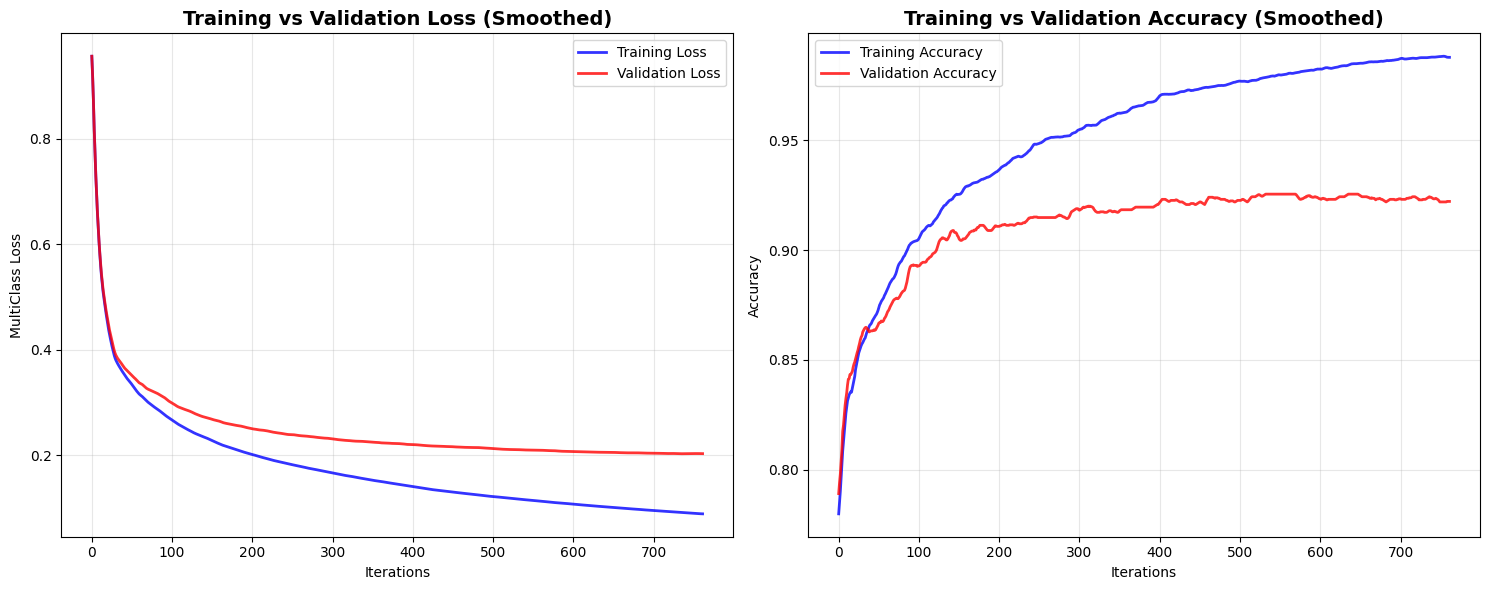


Final Training Statistics:
Final Training Loss: 0.0889
Final Validation Loss: 0.2030
Final Training Accuracy: 0.9878
Final Validation Accuracy: 0.9219
Best Training Loss: 0.0889
Best Validation Loss: 0.2028
Best Training Accuracy: 0.9883
Best Validation Accuracy: 0.9254


In [9]:

# =============================================================================
# STEP 7: TRAINING HISTORY PLOTS (FIXED - WITH SMOOTH ACCURACY CURVES)
# =============================================================================
print("\n" + "="*50)
print("STEP 7: PLOTTING TRAINING HISTORY")
print("="*50)

# Get training history
evals_result = model.get_evals_result()

if 'validation' in evals_result:
    # Extract loss scores
    train_loss = evals_result['learn']['MultiClass']
    val_loss = evals_result['validation']['MultiClass']

    # Extract accuracy scores
    train_accuracy = evals_result['learn']['Accuracy']
    val_accuracy = evals_result['validation']['Accuracy']

    # Apply smoothing to both loss and accuracy curves for better visualization
    from scipy.ndimage import uniform_filter1d

    # Smooth the curves (window size of 5 for smoothing)
    try:
        # Smooth loss curves
        train_loss_smooth = uniform_filter1d(train_loss, size=5, mode='nearest')
        val_loss_smooth = uniform_filter1d(val_loss, size=5, mode='nearest')

        # Smooth accuracy curves (THIS WAS MISSING!)
        train_accuracy_smooth = uniform_filter1d(train_accuracy, size=5, mode='nearest')
        val_accuracy_smooth = uniform_filter1d(val_accuracy, size=5, mode='nearest')

    except:
        # If scipy is not available, use simple moving average
        def moving_average(data, window=5):
            return np.convolve(data, np.ones(window)/window, mode='same')

        # Smooth loss curves
        train_loss_smooth = moving_average(train_loss, 5)
        val_loss_smooth = moving_average(val_loss, 5)

        # Smooth accuracy curves (THIS WAS MISSING!)
        train_accuracy_smooth = moving_average(train_accuracy, 5)
        val_accuracy_smooth = moving_average(val_accuracy, 5)

    # Create plots with smooth curves
    plt.figure(figsize=(15, 6))

    # Plot 1: Training vs Validation Loss (with smoothing)
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_smooth, label='Training Loss', color='blue', linewidth=2, alpha=0.8)
    plt.plot(val_loss_smooth, label='Validation Loss', color='red', linewidth=2, alpha=0.8)
    plt.title('Training vs Validation Loss (Smoothed)', fontsize=14, fontweight='bold')
    plt.xlabel('Iterations')
    plt.ylabel('MultiClass Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Training vs Validation Accuracy (NOW WITH SMOOTHING!)
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_smooth, label='Training Accuracy', color='blue', linewidth=2, alpha=0.8)
    plt.plot(val_accuracy_smooth, label='Validation Accuracy', color='red', linewidth=2, alpha=0.8)
    plt.title('Training vs Validation Accuracy (Smoothed)', fontsize=14, fontweight='bold')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final training statistics (using original unsmoothed values)
    print(f"\nFinal Training Statistics:")
    print(f"Final Training Loss: {train_loss[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")
    print(f"Best Training Loss: {min(train_loss):.4f}")
    print(f"Best Validation Loss: {min(val_loss):.4f}")
    print(f"Best Training Accuracy: {max(train_accuracy):.4f}")
    print(f"Best Validation Accuracy: {max(val_accuracy):.4f}")

else:
    print("No validation scores available for plotting.")


In [10]:

# =============================================================================
# STEP 8: EVALUATE MODEL ON VALIDATION SET
# =============================================================================
print("\n" + "="*50)
print("STEP 8: VALIDATION SET EVALUATION")
print("="*50)

# Make predictions on validation set
y_val_pred = model.predict(X_val)
y_val_pred_proba = model.predict_proba(X_val)

# Calculate all metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision_macro = precision_score(y_val, y_val_pred, average='macro')
val_recall_macro = recall_score(y_val, y_val_pred, average='macro')
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')

# Print validation results
print("VALIDATION SET METRICS:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision (Macro): {val_precision_macro:.4f}")
print(f"Recall (Macro): {val_recall_macro:.4f}")
print(f"F1-Score (Macro): {val_f1_macro:.4f}")
print(f"F1-Score (Weighted): {val_f1_weighted:.4f}")

# Per-class metrics
val_precision_per_class = precision_score(y_val, y_val_pred, average=None)
val_recall_per_class = recall_score(y_val, y_val_pred, average=None)
val_f1_per_class = f1_score(y_val, y_val_pred, average=None)

print(f"\nPER-CLASS METRICS (Validation):")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: Precision={val_precision_per_class[i]:.4f}, "
          f"Recall={val_recall_per_class[i]:.4f}, F1={val_f1_per_class[i]:.4f}")

# Detailed classification report
print(f"\nDETAILED CLASSIFICATION REPORT (Validation):")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))




STEP 8: VALIDATION SET EVALUATION
VALIDATION SET METRICS:
Accuracy: 0.9231
Precision (Macro): 0.9254
Recall (Macro): 0.9231
F1-Score (Macro): 0.9240
F1-Score (Weighted): 0.9234

PER-CLASS METRICS (Validation):
high: Precision=0.9385, Recall=0.9037, F1=0.9208
low: Precision=0.9636, Recall=0.9532, F1=0.9584
medium: Precision=0.8742, Recall=0.9125, F1=0.8929

DETAILED CLASSIFICATION REPORT (Validation):
              precision    recall  f1-score   support

        high       0.94      0.90      0.92       270
         low       0.96      0.95      0.96       278
      medium       0.87      0.91      0.89       297

    accuracy                           0.92       845
   macro avg       0.93      0.92      0.92       845
weighted avg       0.92      0.92      0.92       845



In [11]:

# =============================================================================
# STEP 9: EVALUATE MODEL ON TEST SET
# =============================================================================
print("\n" + "="*50)
print("STEP 9: TEST SET EVALUATION")
print("="*50)

# Make predictions on test set
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)

# Calculate all metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# Print test results
print("TEST SET METRICS:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision (Macro): {test_precision_macro:.4f}")
print(f"Recall (Macro): {test_recall_macro:.4f}")
print(f"F1-Score (Macro): {test_f1_macro:.4f}")
print(f"F1-Score (Weighted): {test_f1_weighted:.4f}")

# Per-class metrics
test_precision_per_class = precision_score(y_test, y_test_pred, average=None)
test_recall_per_class = recall_score(y_test, y_test_pred, average=None)
test_f1_per_class = f1_score(y_test, y_test_pred, average=None)

print(f"\nPER-CLASS METRICS (Test):")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: Precision={test_precision_per_class[i]:.4f}, "
          f"Recall={test_recall_per_class[i]:.4f}, F1={test_f1_per_class[i]:.4f}")

# Detailed classification report
print(f"\nDETAILED CLASSIFICATION REPORT (Test):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))



STEP 9: TEST SET EVALUATION
TEST SET METRICS:
Accuracy: 0.9325
Precision (Macro): 0.9340
Recall (Macro): 0.9328
F1-Score (Macro): 0.9331
F1-Score (Weighted): 0.9329

PER-CLASS METRICS (Test):
high: Precision=0.9537, Recall=0.9210, F1=0.9371
low: Precision=0.9703, Recall=0.9526, F1=0.9613
medium: Precision=0.8780, Recall=0.9250, F1=0.9009

DETAILED CLASSIFICATION REPORT (Test):
              precision    recall  f1-score   support

        high       0.95      0.92      0.94       291
         low       0.97      0.95      0.96       274
      medium       0.88      0.93      0.90       280

    accuracy                           0.93       845
   macro avg       0.93      0.93      0.93       845
weighted avg       0.93      0.93      0.93       845




STEP 10: PLOTTING CONFUSION MATRICES


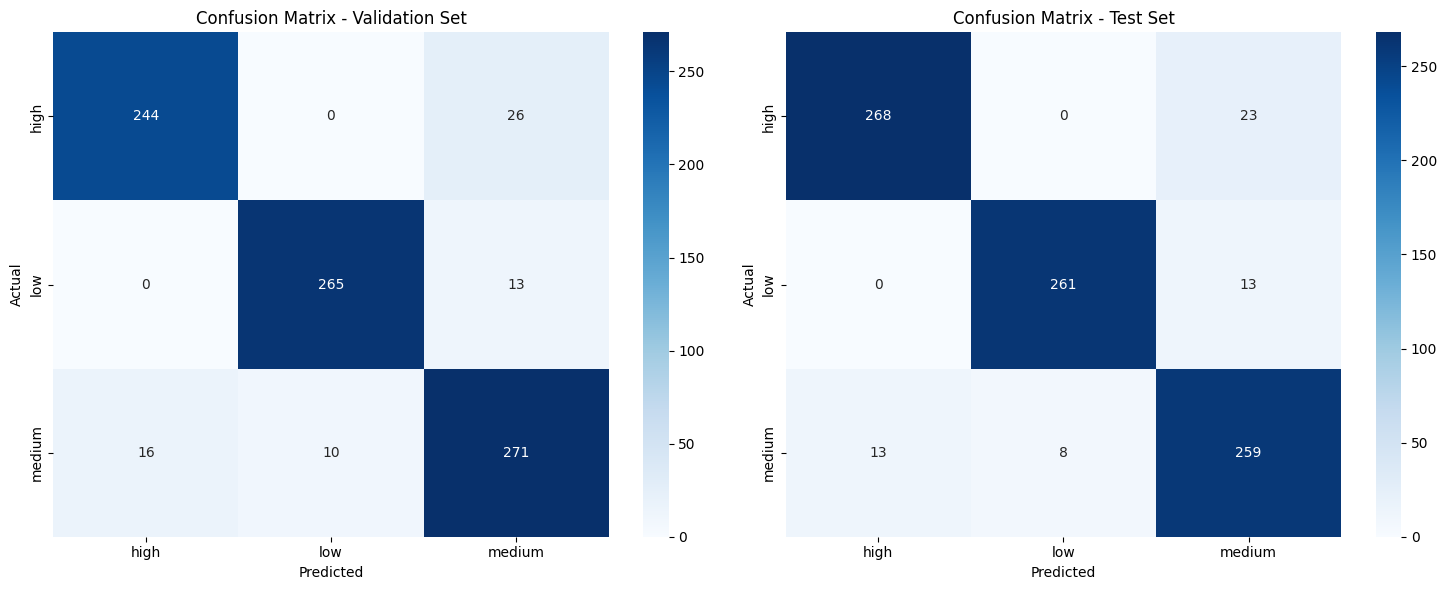

In [12]:


# =============================================================================
# STEP 10: PLOT CONFUSION MATRICES
# =============================================================================
print("\n" + "="*50)
print("STEP 10: PLOTTING CONFUSION MATRICES")
print("="*50)

# Create confusion matrices
val_cm = confusion_matrix(y_val, y_val_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(15, 6))

# Validation confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Test confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


In [13]:
# =============================================================================
# STEP 11: FEATURE IMPORTANCE ANALYSIS
# =============================================================================
print("\n" + "="*50)
print("STEP 12: FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature importance
feature_importance = model.get_feature_importance()
feature_names = feature_columns

# Create DataFrame for easier handling
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))



STEP 12: FEATURE IMPORTANCE ANALYSIS
Top 20 Most Important Features:
                                         feature  importance
                                    Area (Acres)   44.971693
                                    Crop_Cabbage    5.183570
                                            Year    4.512122
                                      Crop_Beans    4.099120
                                     Crop_Garlic    3.677905
                                    Crop_Laushak    3.432935
                                     Crop_Tomato    3.249264
               Temperature at 2 Meters Range (C)    3.230309
                    soil_temperature_0_to_7cm(C)    2.933156
                                     Crop_Radish    2.898933
                                Crop_Cauliflower    2.520118
                 soil_moisture_0_to_7cm(mÂ³/mÂ³)    2.434671
                         relative_humidity_2m(%)    2.050042
                                      Crop_Onion    1.897459
               

In [14]:
# =============================================================================
# STEP 12: FINAL SUMMARY AND RESULTS
# =============================================================================
print("\n" + "="*60)
print("STEP 13: FINAL SUMMARY AND RESULTS")
print("="*60)

print("QUANTILE THRESHOLDS:")
print(f"Low production threshold: {low_threshold:.2f} M.Ton")
print(f"High production threshold: {high_threshold:.2f} M.Ton")

print(f"\nMODEL TRAINING SUMMARY:")
print(f"Total features used: {len(feature_columns)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Best iteration: {model.get_best_iteration()}")

print(f"\nVALIDATION SET PERFORMANCE:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Macro F1-Score: {val_f1_macro:.4f}")
print(f"Weighted F1-Score: {val_f1_weighted:.4f}")

print(f"\nTEST SET PERFORMANCE:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Macro F1-Score: {test_f1_macro:.4f}")
print(f"Weighted F1-Score: {test_f1_weighted:.4f}")

print(f"\nTOP 5 MOST IMPORTANT FEATURES:")
for i, row in importance_df.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.2f}")

print(f"\n{'='*60}")
print("ENHANCED CLASSIFICATION MODEL COMPLETED SUCCESSFULLY!")
print("="*60)



STEP 13: FINAL SUMMARY AND RESULTS
QUANTILE THRESHOLDS:
Low production threshold: 1071.56 M.Ton
High production threshold: 4035.91 M.Ton

MODEL TRAINING SUMMARY:
Total features used: 83
Training samples: 3942
Validation samples: 845
Test samples: 845
Best iteration: 731

VALIDATION SET PERFORMANCE:
Accuracy: 0.9231
Macro F1-Score: 0.9240
Weighted F1-Score: 0.9234

TEST SET PERFORMANCE:
Accuracy: 0.9325
Macro F1-Score: 0.9331
Weighted F1-Score: 0.9329

TOP 5 MOST IMPORTANT FEATURES:
Area (Acres): 44.97
Crop_Cabbage: 5.18
Year: 4.51
Crop_Beans: 4.10
Crop_Garlic: 3.68

ENHANCED CLASSIFICATION MODEL COMPLETED SUCCESSFULLY!


In [15]:
# =============================================================================
# STEP 13: SAMPLE PREDICTIONS (BONUS)
# =============================================================================
print("\n" + "="*50)
print("STEP 14: SAMPLE PREDICTIONS")
print("="*50)

# Show some sample predictions
sample_size = min(10, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)

print("Sample Predictions vs Actual Values:")
print("-" * 80)
print("Index  Actual   Predicted  Confidence   Correct")
print("-" * 80)

for i, idx in enumerate(sample_indices):
    # Get the actual values safely
    idx_val = int(idx)
    actual_class_idx = int(y_test[idx])
    pred_class_idx = int(y_test_pred[idx])

    # Get class names
    actual_label = label_encoder.classes_[actual_class_idx]
    pred_label = label_encoder.classes_[pred_class_idx]

    # Get confidence (convert numpy array to float)
    confidence_val = y_test_pred_proba[idx]
    max_confidence = float(np.max(confidence_val))

    # Check if correct
    is_correct = "✓" if actual_label == pred_label else "✗"

    # Print using .format() instead of f-strings to avoid numpy issues
    print("{:<6} {:<8} {:<10} {:.3f}       {}".format(
        idx_val, actual_label, pred_label, max_confidence, is_correct
    ))

print("\n" + "="*60)
print("ALL STEPS COMPLETED! Your Enhanced CatBoost model is ready for use.")
print("="*60)


STEP 14: SAMPLE PREDICTIONS
Sample Predictions vs Actual Values:
--------------------------------------------------------------------------------
Index  Actual   Predicted  Confidence   Correct
--------------------------------------------------------------------------------
392    medium   high       0.562       ✗
284    low      low        0.997       ✓
263    high     high       0.998       ✓
279    low      low        0.879       ✓
602    low      low        0.971       ✓
368    medium   medium     0.986       ✓
554    medium   medium     0.967       ✓
233    low      low        0.998       ✓
628    medium   medium     0.933       ✓
331    low      low        0.990       ✓

ALL STEPS COMPLETED! Your Enhanced CatBoost model is ready for use.
